In [35]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange
from dots.training import *
from dots.trainhooks import *
from dots.models import MLP
from dots.dots import *
from dots.utils import *
from dots.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def sawtooth_mlp(layers):
    hidden = [2 ** layers] + flatten([[1, 2] for _ in range(layers - 1)])
    mlp = MLP(1, 1, hidden=hidden)
    return mlp

In [5]:
sawtooth_mlp(4).layers

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1, out_features=2, bias=True)
  (9): ReLU()
  (10): Linear(in_features=2, out_features=1, bias=True)
  (11): ReLU()
  (12): Linear(in_features=1, out_features=2, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2, out_features=1, bias=True)
)

In [6]:
sawtooth_mlp(4).layers[0].weight

Parameter containing:
tensor([[ 0.2816],
        [ 0.9625],
        [-0.8717],
        [ 0.8657],
        [ 0.1260],
        [ 0.5312],
        [ 0.4979],
        [-0.7959],
        [-0.3861],
        [ 0.5437],
        [-0.3608],
        [ 0.5796],
        [-0.9721],
        [ 0.7709],
        [-0.2147],
        [-0.8142]], requires_grad=True)

In [7]:
sawtooth_mlp(4).layers[0].bias

Parameter containing:
tensor([ 0.9125, -0.4130,  0.9733,  0.1040, -0.0363, -0.3000,  0.9015, -0.0883,
        -0.3305, -0.4169, -0.4155,  0.4566,  0.7753,  0.6297, -0.1461, -0.0515],
       requires_grad=True)

In [22]:
def deep_sawtooth(layers):
    model = sawtooth_mlp(layers)
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    ## implement identity:
    #model.layers[0].weight.data[0] = 1.0
    #model.layers[2].weight.data[0] = 1.0
    #for i in range(4, len(model.layers), 2):
    #model.layers[i].weight.data[0] = 1.0
    for i in range(0, len(model.layers), 4):
        j = i + 2
        model.layers[i].weight.data[0][0] = 1.0
        model.layers[j].weight.data[0][0] = 2.0
        model.layers[i].weight.data[1][0] = 1.0
        model.layers[i].bias.data[1] = -0.5
        model.layers[j].weight.data[0][1] = -4.0
    return model

def deep_only_sawtooth(layers):
    model = MLP(1, 1, flatten([[2, 1] for i in range(layers)])[:-1])
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    for i in range(0, len(model.layers), 4):
        j = i + 2
        model.layers[i].weight.data[0][0] = 1.0
        model.layers[j].weight.data[0][0] = 2.0
        model.layers[i].weight.data[1][0] = 1.0
        model.layers[i].bias.data[1] = -0.5
        model.layers[j].weight.data[0][1] = -4.0
    return model 

def shallow_sawtooth(layers):
    model = sawtooth_mlp(layers)
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    for i in range(4, len(model.layers), 2):
        model.layers[i].weight.data[0] = 1.0
    for i in range(0, 2**layers):
        slope = 2 if i % 2 == 0 else -2
        if i == 0:
            slope = 1
        model.layers[2].weight.data[0][i] = slope * (2 ** layers)
        model.layers[0].weight.data[i][0] = 1.0
        model.layers[0].bias.data[i] = -i / (2 ** layers)
    return model

def shallow_only_sawtooth(layers):
    model = MLP(1, 1, [2**layers])
    for i in range(0, len(model.layers), 2):
        model.layers[i].weight.data.fill_(0)
        model.layers[i].bias.data.fill_(0)
    for i in range(0, 2**layers):
        slope = 2 if i % 2 == 0 else -2
        if i == 0:
            slope = 1
        model.layers[2].weight.data[0][i] = slope * (2 ** layers)
        model.layers[0].weight.data[i][0] = 1.0
        model.layers[0].bias.data[i] = -i / (2 ** layers)
    return model

In [23]:
#model = deep_only_sawtooth(4)
#for i in range(0, len(model.layers), 2):
#    print(f"weight: {deep_only_sawtooth(4).layers[i].weight}")
#    print(f"bias: {deep_only_sawtooth(4).layers[i].bias}")

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


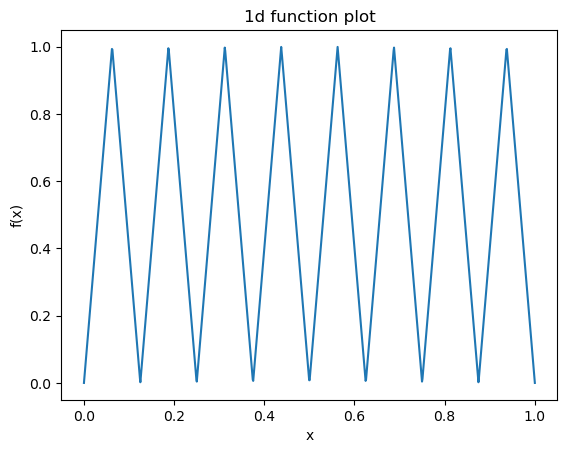

In [24]:
plot_1d_fn(deep_only_sawtooth(4), 0, 1, 1000)

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


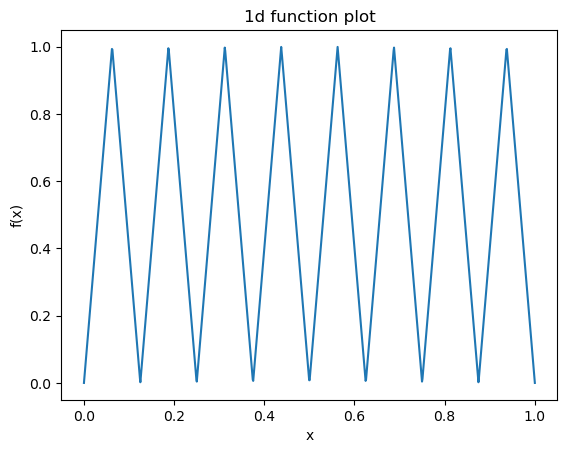

In [25]:
plot_1d_fn(deep_sawtooth(4), 0, 1, 1000)

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


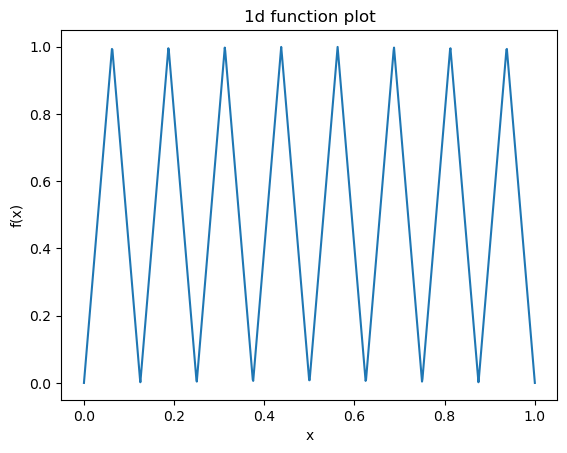

In [26]:
plot_1d_fn(shallow_only_sawtooth(4), 0, 1, 1000)

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


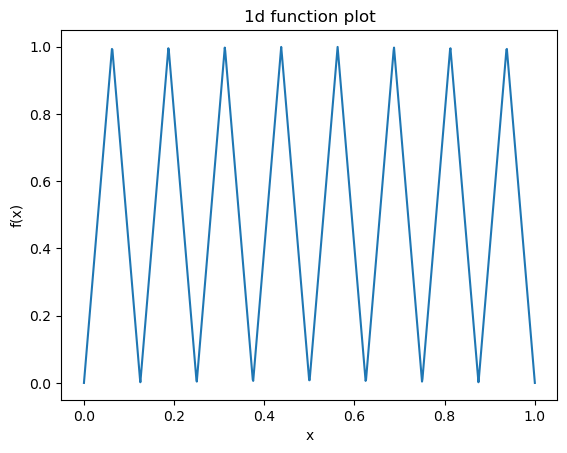

In [27]:
plot_1d_fn(shallow_sawtooth(4), 0, 1, 1000)

In [15]:
jac = matrix_jacobian(deep_sawtooth(4), range_batch(0, 1, 1000))

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


In [16]:
t.linalg.svd(jac)

torch.return_types.linalg_svd(
U=tensor([[-4.3179e-02,  2.8192e-02, -3.4496e-03,  ...,  7.4734e-04,
          6.5027e-04,  9.5174e-04],
        [ 4.5061e-02, -2.9623e-02,  4.0521e-03,  ..., -8.1377e-03,
          7.9602e-03,  3.0495e-03],
        [ 4.3896e-02,  2.3538e-02,  3.1565e-02,  ..., -1.3080e-04,
          7.9616e-05,  5.9137e-06],
        ...,
        [ 4.2210e-02, -3.5353e-02, -1.2615e-02,  ...,  9.7823e-01,
         -1.3989e-03, -4.6029e-03],
        [ 4.2339e-02,  2.2100e-02,  1.6053e-02,  ..., -2.6993e-03,
          9.8210e-01, -1.6722e-03],
        [ 4.4304e-02,  2.2479e-02,  3.2604e-02,  ..., -5.4903e-03,
         -2.5135e-03,  9.8463e-01]]),
S=tensor([1.0876e+03, 5.2619e+02, 3.4917e+02, 2.3233e+02, 1.1354e+02, 8.7206e+01,
        4.7128e+01, 2.4257e+01, 1.4256e+01, 1.0471e+01, 1.5949e-04, 1.4042e-04,
        1.0060e-04, 7.2369e-05, 6.0968e-05, 6.0968e-05, 6.0968e-05, 6.0968e-05,
        6.0968e-05, 6.0968e-05, 6.0968e-05, 6.0968e-05, 6.0968e-05, 6.0968e-05,
        6.09

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

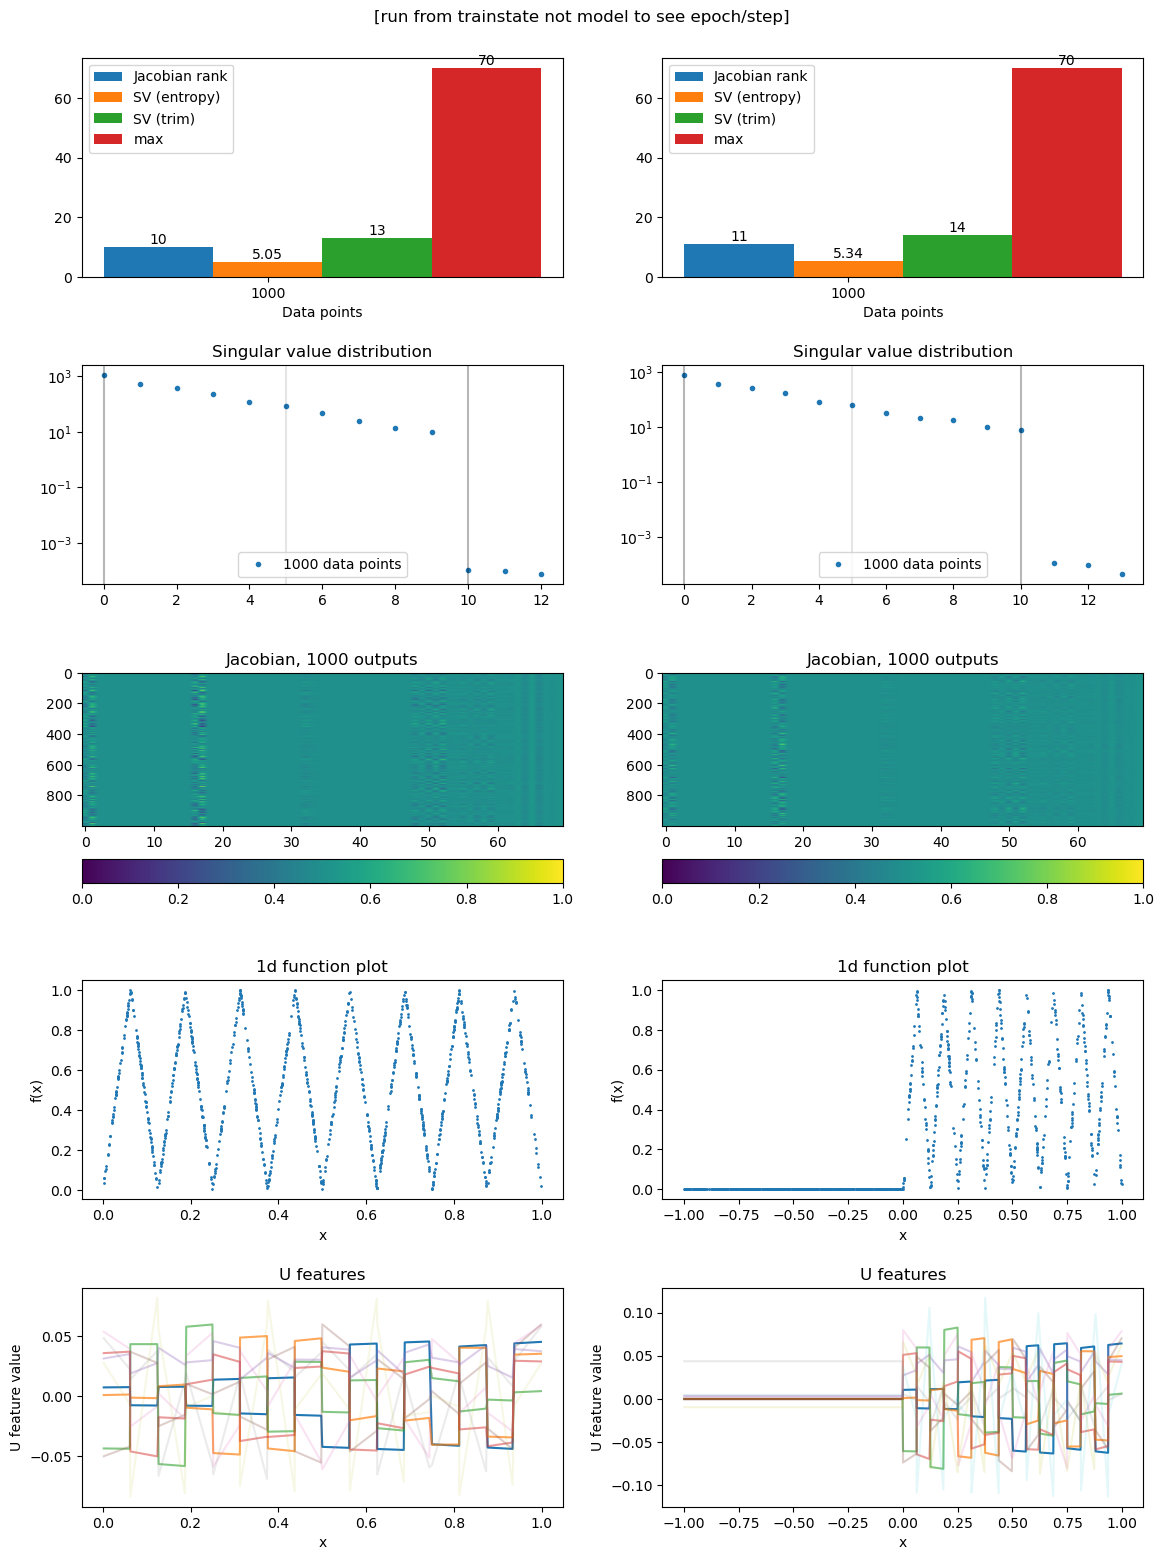

In [132]:
fig = trainplot_1d(deep_sawtooth(4), range_batch(0, 1, 1000))

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

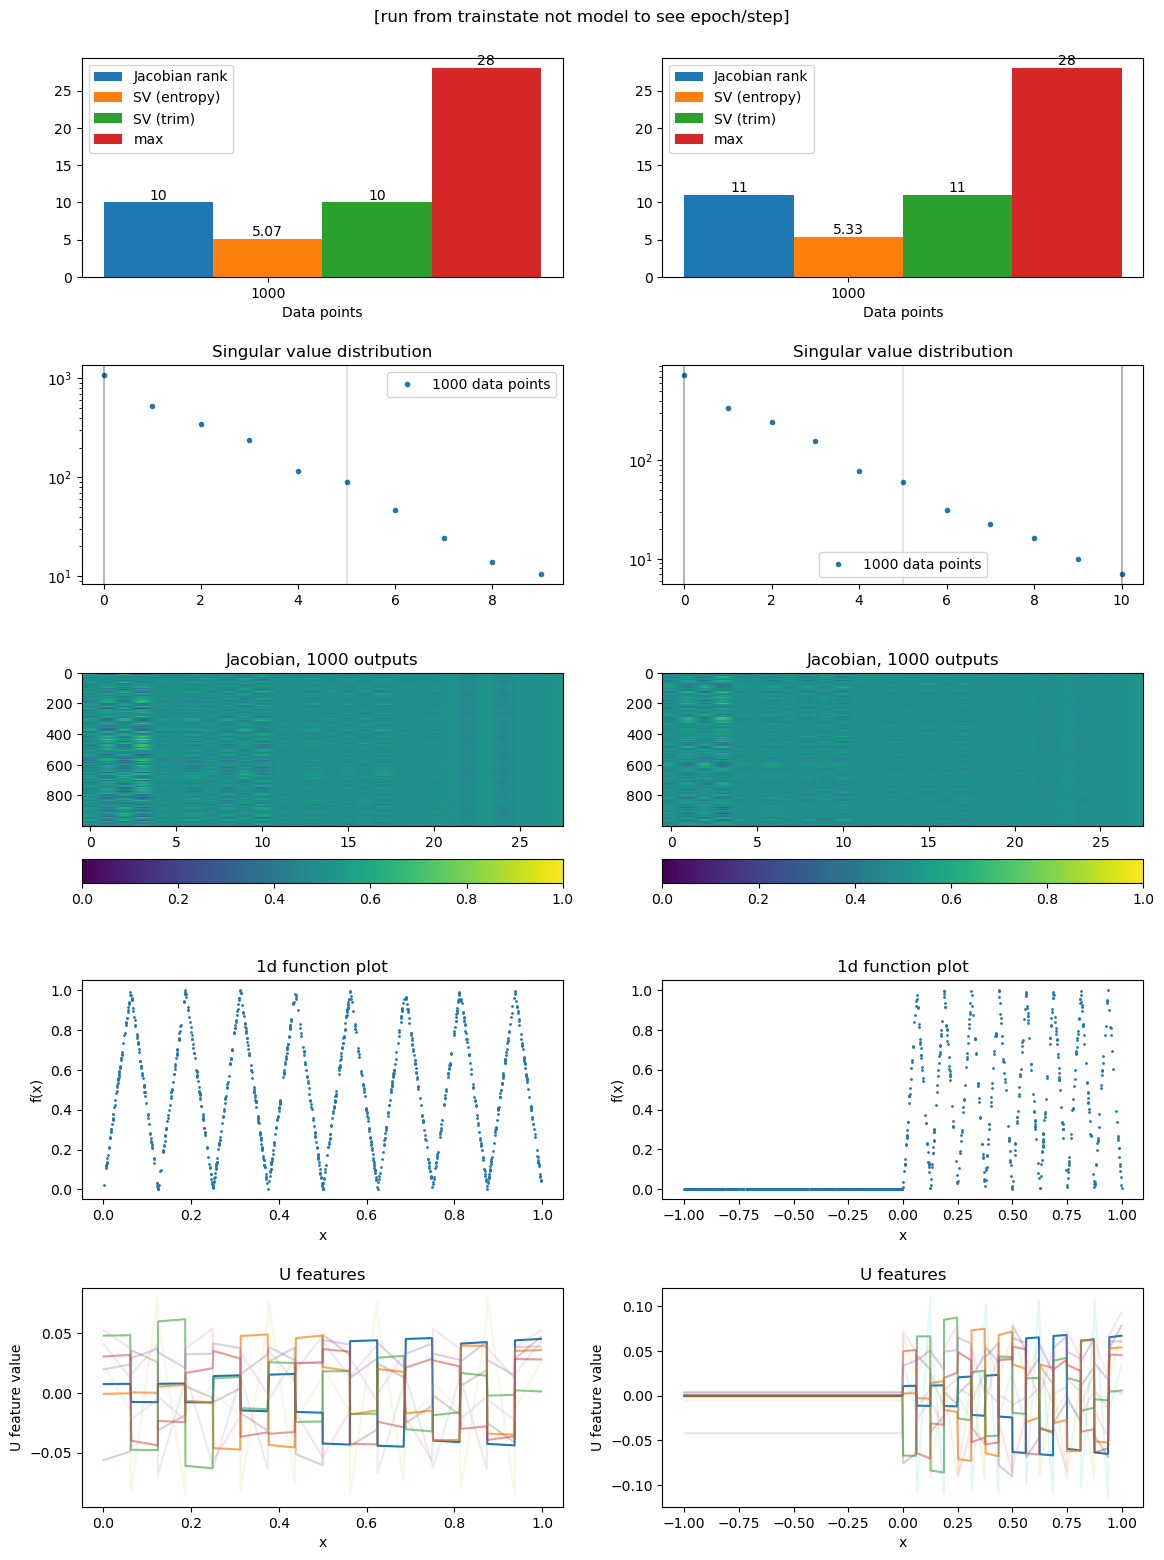

In [29]:
fig = trainplot_1d(deep_only_sawtooth(4), range_batch(0, 1, 1000))

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

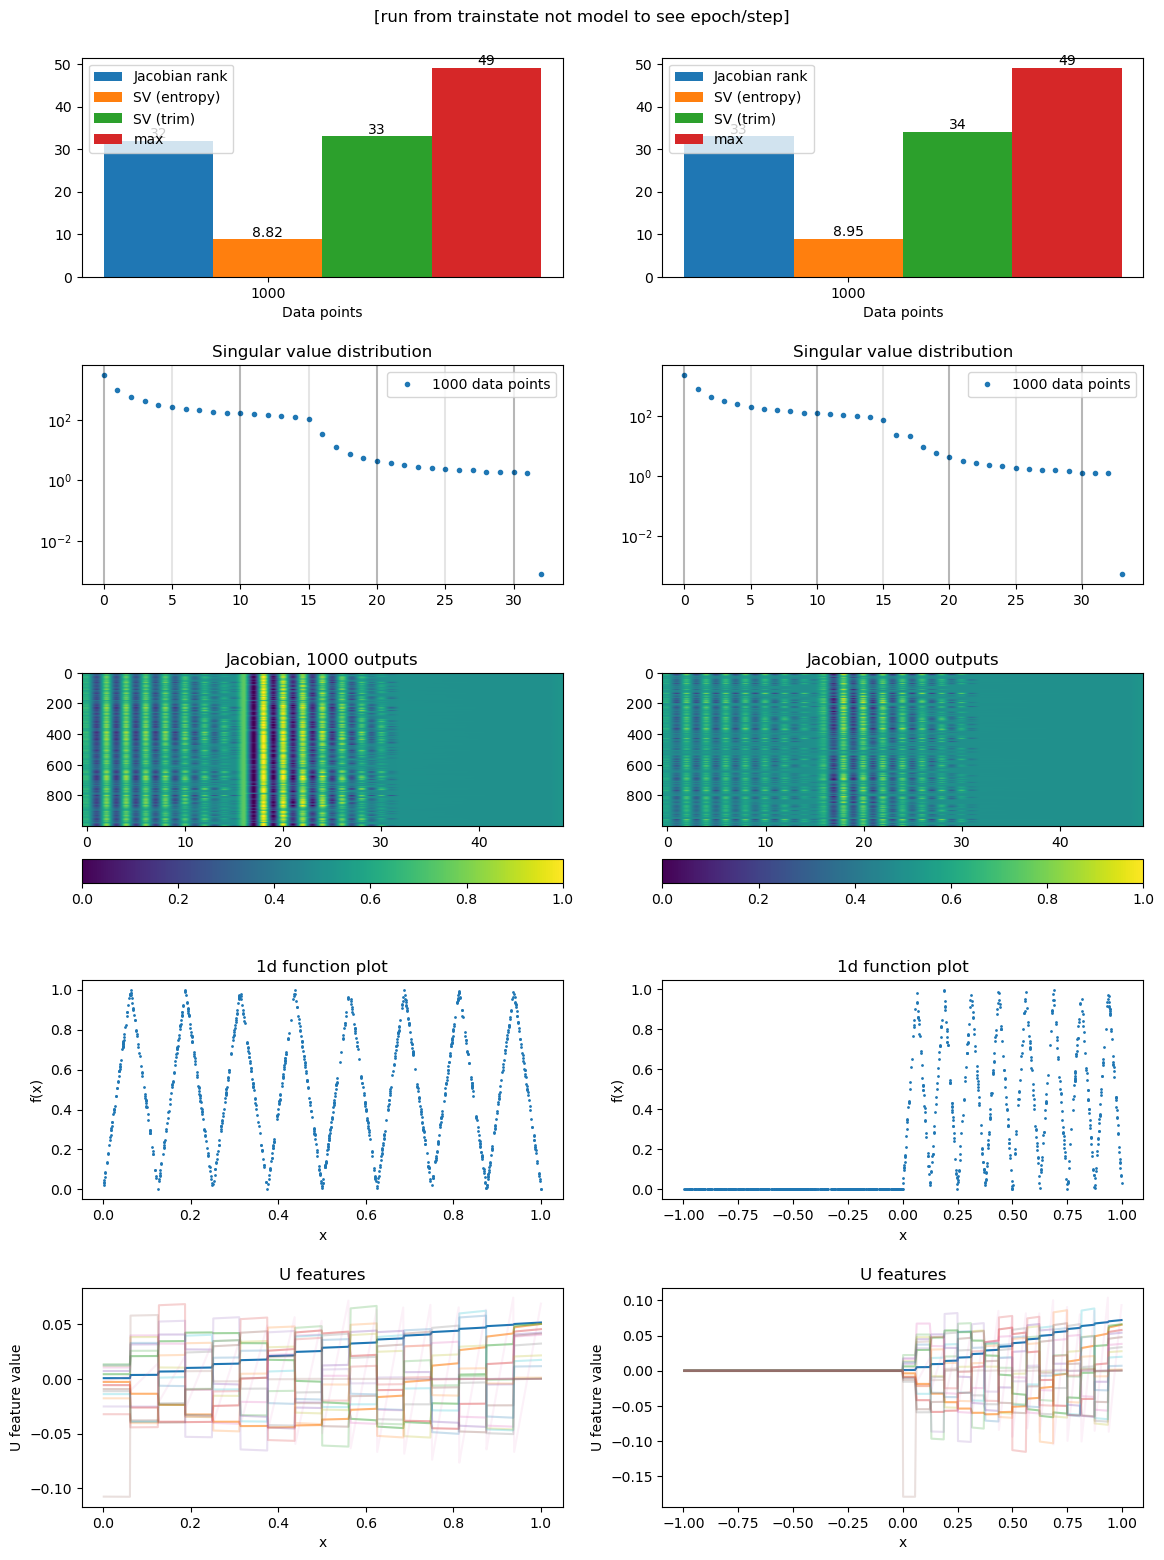

In [30]:
fig = trainplot_1d(shallow_only_sawtooth(4), range_batch(0, 1, 1000))

Assuming trainplot_1d got a model, not a trainstate


/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-pack

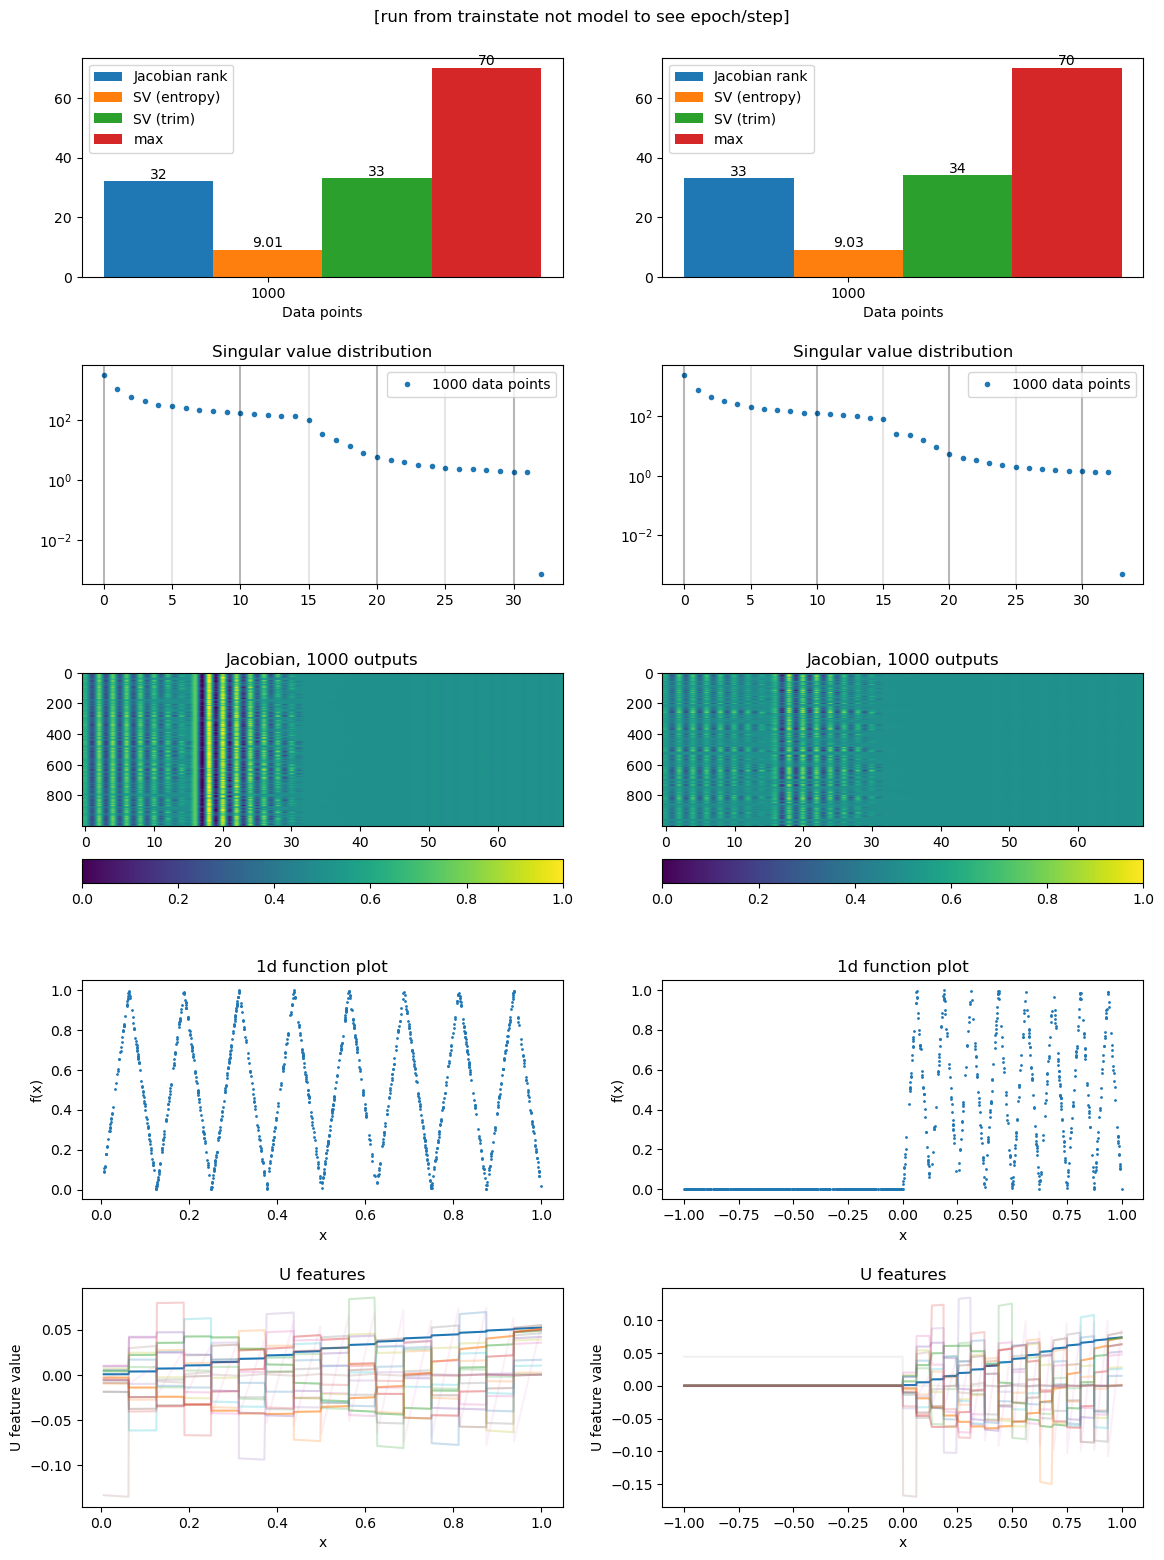

In [133]:
fig = trainplot_1d(shallow_sawtooth(4), range_batch(0, 1, 1000))

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


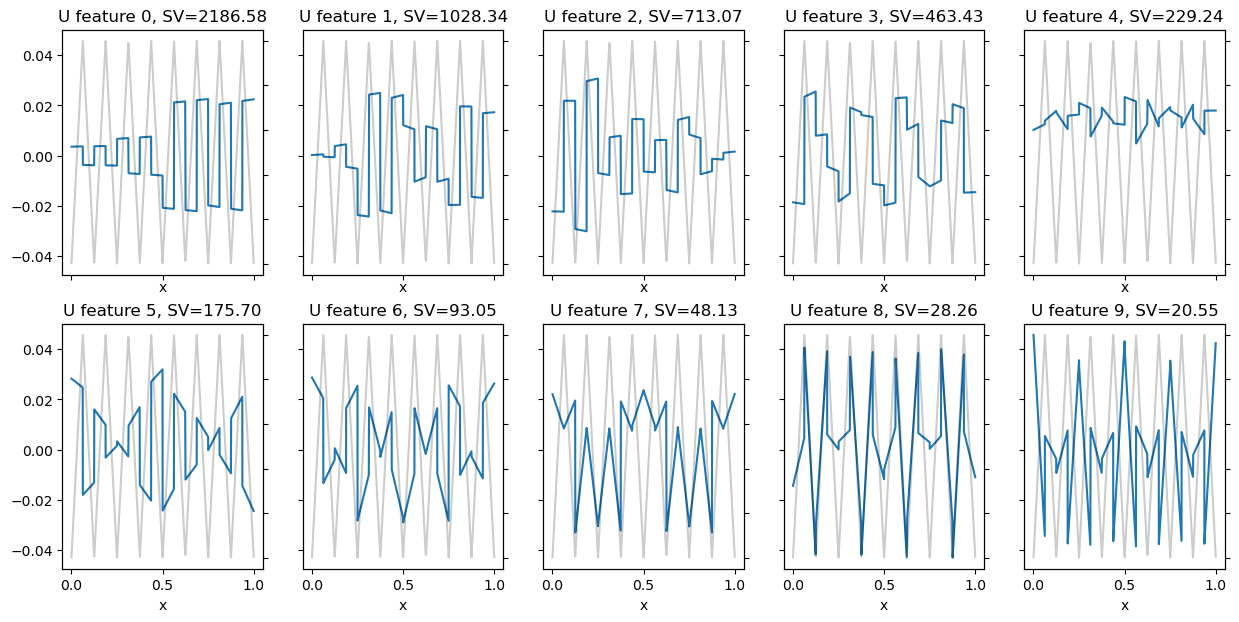

In [40]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.flatten()
plot_1d_u_feats(deep_sawtooth(4), range_batch(0, 1, 4000), plot_fn=True, max_feats=len(axs), flip="function", ax=axs)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


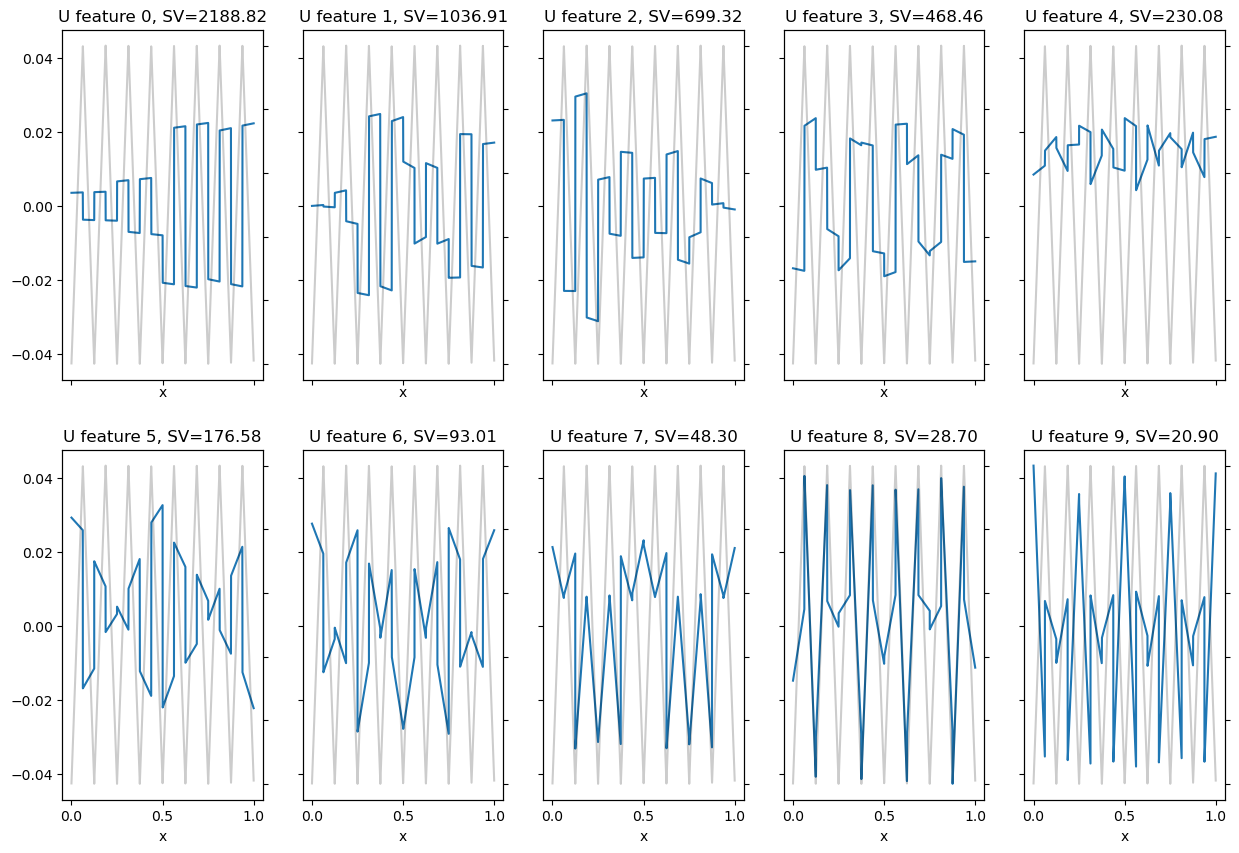

In [31]:
fig, axs = plt.subplots(2, 5, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
plot_1d_u_feats(deep_only_sawtooth(4), range_batch(0, 1, 4000), plot_fn=True, max_feats=len(axs), flip="function", ax=axs)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


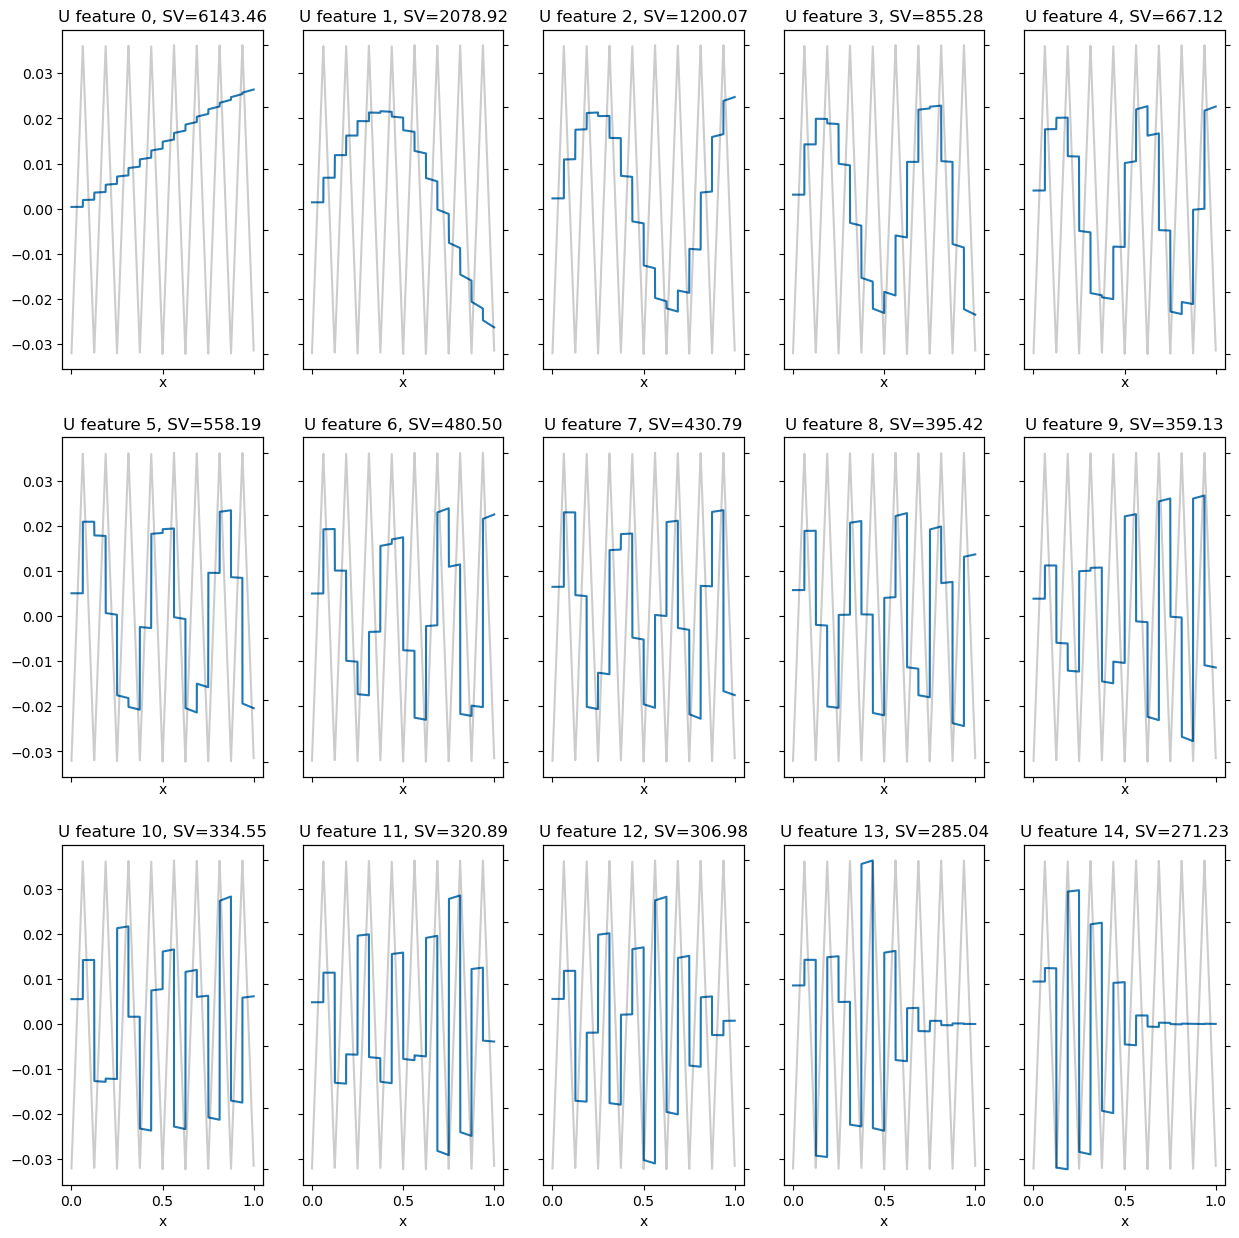

In [32]:
fig, axs = plt.subplots(3, 5, figsize=(15, 15), sharex=True, sharey=True)
axs = axs.flatten()
plot_1d_u_feats(shallow_only_sawtooth(4), range_batch(0, 1, 4000), plot_fn=True, max_feats=len(axs), flip="function", ax=axs)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


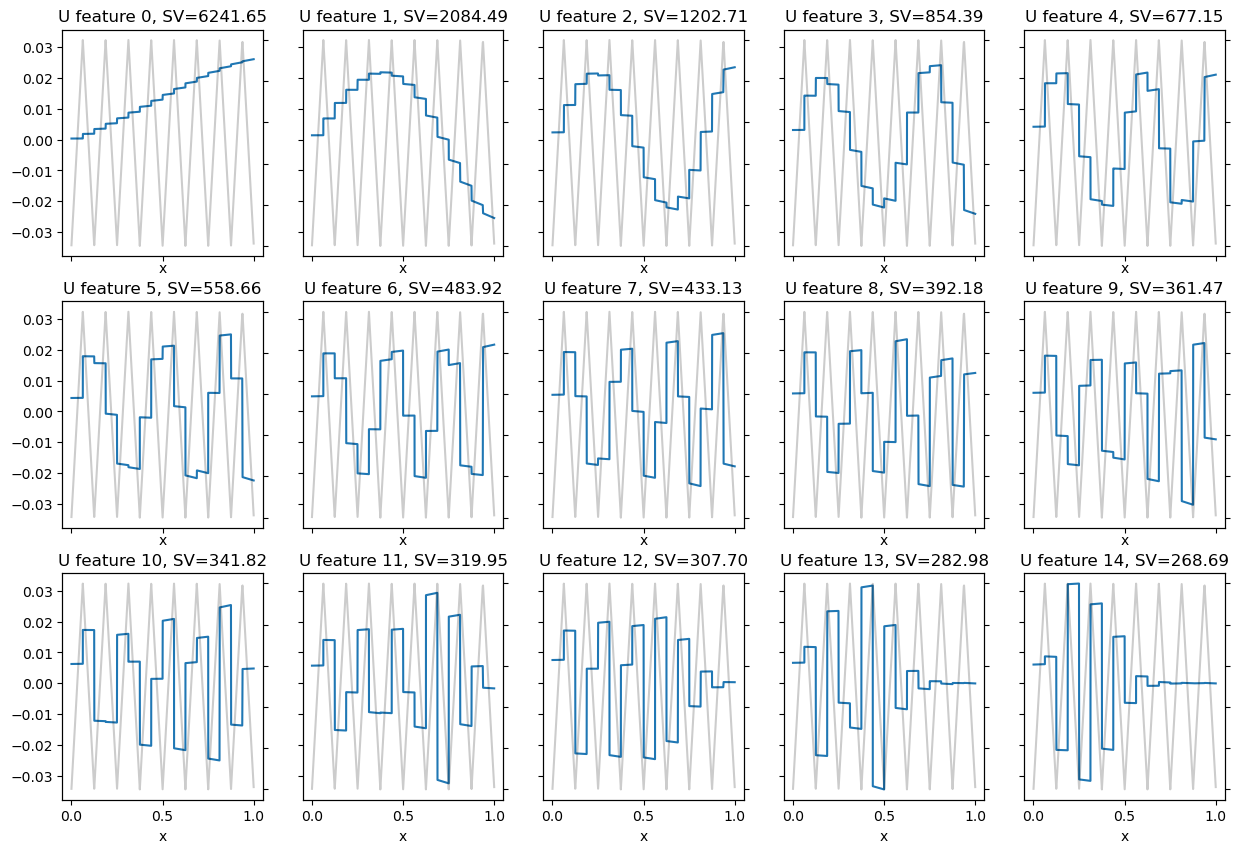

In [41]:
fig, axs = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
plot_1d_u_feats(shallow_sawtooth(4), range_batch(0, 1, 4000), plot_fn=True, max_feats=len(axs), flip="function", ax=axs)

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/plotting.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  flip=True,


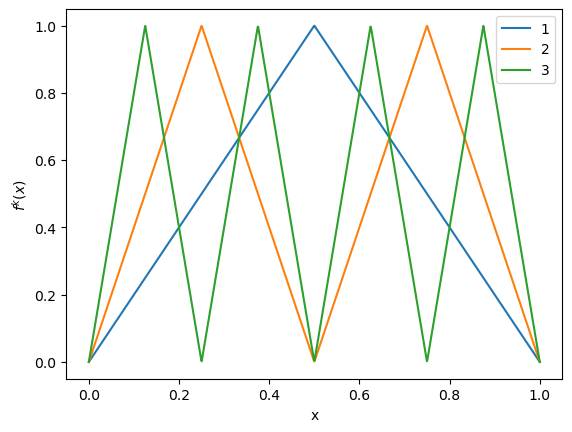

In [39]:
plot_1d_fns(
    [deep_sawtooth(k) for k in range(1, 4)],
    start=0,
    end=1,
    ylabel="$f^k(x)$",
    labels=[1, 2, 3]
)